In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from skimage.segmentation import mark_boundaries
import lime
from lime.lime_image import LimeImageExplainer
from lime import lime_image

/home/rosengaard/miniforge3/envs/and3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Load model(Mei pre: ImageNet):
current_directory = os.environ['HOME']
model_path = os.path.join(current_directory, "radimagenet/Anders/Eksperiment2/Mei/PreImgNet/weights/Eks2_Mei_ResNet50_ImgNet.h5")
loaded_model = load_model(model_path)

2023-12-09 23:35:30.004216: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#Images for the report:
#Malignant (Cancer):
image_path_m1 = os.path.join(current_directory, "radimagenet/Anders/Eksperiment2/Data/poc_breast_dataset/Images/2.png")
image_path_m2 = os.path.join(current_directory, "radimagenet/Anders/Eksperiment2/Data/poc_breast_dataset/Images/4.png")
image_path_m3 = os.path.join(current_directory, "radimagenet/Anders/Eksperiment2/Data/poc_breast_dataset/Images/6.png") 
image_path_m4 = os.path.join(current_directory, "radimagenet/Anders/Eksperiment2/Data/poc_breast_dataset/Images/8.png")

#Not room for more...
#Benign:
#image_path_b1 = os.path.join(current_directory, "radimagenet/Anders/Eksperiment2/Data/poc_breast_dataset/Images/1.png")
#image_path_b2 = os.path.join(current_directory, "radimagenet/Anders/Eksperiment2/Data/poc_breast_dataset/Images/5.png")
#image_path_b3 = os.path.join(current_directory, "radimagenet/Anders/Eksperiment2/Data/poc_breast_dataset/Images/17.png")
#image_path_b4 = os.path.join(current_directory, "radimagenet/Anders/Eksperiment2/Data/poc_breast_dataset/Images/2402.png")

2023-12-09 23:35:40.956447: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-12-09 23:35:40.968513: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz


[[0.21326265 0.7867374 ]]
1


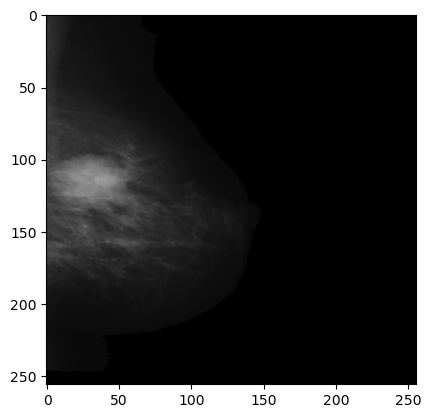

In [4]:
# Load and resize to fit the model:
input_image = Image.open(image_path_m2)
input_image = input_image.resize((256, 256))
input_image = input_image.convert("RGB")
input_image = np.array(input_image) / 255.0  # Rescale image
plt.imshow(input_image)

explainer = LimeImageExplainer()
predictions = loaded_model.predict(np.expand_dims(input_image, axis=0))
print(predictions)
top_class_index = np.argmax(predictions)
print(top_class_index)

In [5]:
explanation = explainer.explain_instance(input_image, 
                                         loaded_model.predict, 
                                         top_labels=2, 
                                         hide_color=None, # Hide color is the color for a superpixel turned OFF.  NONE = the superpixel will be replaced by the average of its pixels 
                                         num_samples=2000)

100%|██████████| 2000/2000 [01:32<00:00, 21.66it/s]


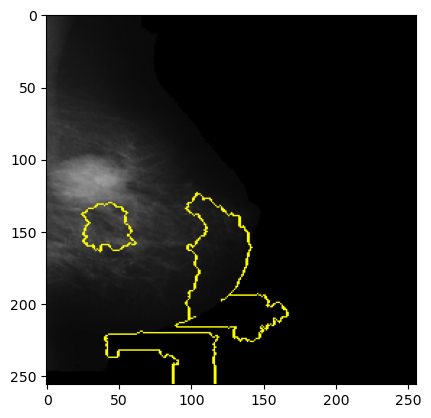

In [6]:
# Include the rest of the image
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=True, num_features=4, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask));

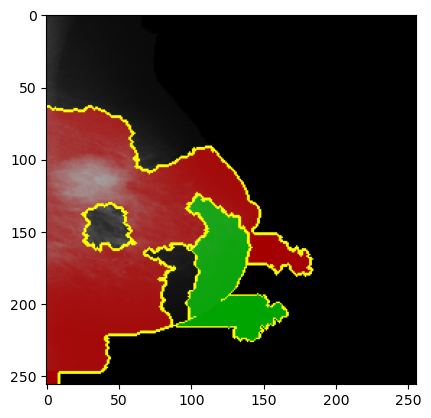

In [7]:
# View the pros and cons
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask));

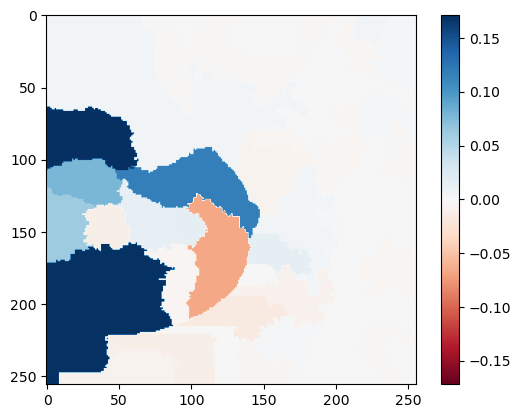

In [8]:
#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[1])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar();